## Importing Libraries

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from joblib import load
from lightgbm import LGBMClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

## Functions for data Pre-processing

In [3]:
def one_hot_encoding(dataframe):
    '''Function to one hot encode categorical features given dataframe'''
    ohe_features = [col for col in dataframe.columns if "cat" in str(col)]
    
    ohe = load('ohe.joblib')    
    cols = ohe.get_feature_names_out()
    ohe_encoded = ohe.transform(dataframe[ohe_features]).toarray()
    
    ohe_encoded_df = pd.DataFrame(data = ohe_encoded, columns = cols, index = dataframe.index)
    
    
    dataframe =  dataframe.drop(columns=ohe_features)
    encoded_dataframe = pd.concat([dataframe, ohe_encoded_df], axis=1)

    return encoded_dataframe

In [4]:
def standardizing_continuous_features(dataframe):
    '''Function to standardize numerical features given dataframe'''
    scaler = load('standard_scaler.joblib')  
    continuous_features = scaler.get_feature_names_out() #[col for col in dataframe.columns if "bin" not in col and "cat" not in col ]
    dataframe[continuous_features] = scaler.transform(dataframe[continuous_features])
    
    return dataframe

In [5]:
def fill_missing_values(df):
    '''Function to fill missing values in a given dataframe'''
    fill_with_mode = ['ps_ind_02_cat', 'ps_ind_04_cat', 'ps_ind_05_cat', 'ps_car_01_cat', 'ps_car_02_cat','ps_car_07_cat',
                          'ps_car_09_cat']
    fill_with_mean = ['ps_car_11' , 'ps_car_12' , 'ps_car_14']
    df = df.copy()                                          # Using copy so that original dataframe values are not changed
    df['missing'] = (abs(df[df == -1].sum(axis = 1))).astype(int)   # Add a new 'missing' feature that specifies how many
                                                            # feature values were originally missing in each datapoint
    for col in fill_with_mode:
        df[col] = df[col].replace(-1,df[col].mode()[0])     # Replacing '-1' with the value that occured the most in this column
    for col in fill_with_mean:
        df[col] = df[col].replace(-1, df[col].mean())       # Replacing '-1' with the mean of the column values
    return df

## Function to calculate Performance Metric

In [6]:
# https://www.kaggle.com/code/batzner/gini-coefficient-an-intuitive-explanation
# https://www.kaggle.com/c/ClaimPredictionChallenge/discussion/703

def gini(actual, pred):  
    
    '''Function to calculate gini coefficient given actual and predicted values'''
    
    assert( len(actual) == len(pred) )  
    all_ = np.asarray(np.c_[ actual, pred, np.arange(len(actual)) ], dtype= float) # Concatenate [actual_val, pred_val, index]
    
    all_ = all_[ np.lexsort((all_[:,2], -1*all_[:,1])) ]  # lexsort returns indices 
                                                          # sort first based on 2nd column, then sort based on 3rd column 
                                                          # so first sort in descending order based on predicted val
                                                          #if predicted val are equal sort based on index in ascending order
                                                             
    totalLosses = all_[:,0].sum()                         # Sum of actual values
    
    giniSum = all_[:,0].cumsum().sum() / totalLosses      # Get cumulative sum of actual values in a list like [1,2,3,4,4,5]
                                                          # then sum the list values of cumulative sum
                                                          # divide the value we get by sum of actual values
    
    giniSum -= (len(actual) + 1) / 2                      # ginisum = ginisum - ((number_of_data_points + 1)/2)
    
    return giniSum / len(actual)                          # gini_coefficient = ginisum/number_of_data_points
  
def gini_normalized(a, p):  
    '''Function to calculate the normalized gini coefficient given actual and predicted values'''
    
    return (gini(a, p) / gini(a, a)) # normalized_gini = gini_coefficient_of_actual_predicter/gini_coefficient_of_actual_actual
                                     # gini_coefficient_of_actual_actual is the maximum value the gini_coefficient can have
                                     # for the given data  


## Function to plot confusion matrix

In [7]:
def plot_confusion_matrix(estimator, dataframe, target):
    ''' Function to plot confusion matrix of cv data. 
    Function call should have the arguments:
    estimator : The trained machine learning or deep learning model. 
    dataframe: dataframe using which the estimator model will predict the classes
    target: The actual classes of datapoints'''
    
    plt.figure(figsize=(5,3)) 
    plt.title('Confusion matrix')
    sns.heatmap(confusion_matrix(target, estimator.predict(dataframe)), annot = True, fmt ='g')
    plt.xlabel("Predicted Class")
    plt.ylabel("True class");

## Function to test the performance of LightGBM Model

In [8]:
def test_pipe_line(df, target = None):
    """Function to do data pre-processing, classification, display chosen metrics and return the predicted probabilities 
       for class 1 (customer will claim insurance)
    Function call should have the arguments:
    df : The input dataframe
    target: Optional argument. The actual classes of datapoints. If value is not provided, 
            function will check for a column named 'target' within the input dataframe. """
    
    df = df.copy()                   # Using copy so that original dataframe values are not changed
    
    # Dropping all continuous calc features as they are not useful in classifying the target variable
    continuous_calc_features = [col for col in df.columns if "calc" in col and "bin" not in col]   
    df.drop(continuous_calc_features, axis = 1, inplace = True)

    # Dropping feature 'id' as it is an identifier and is not useful for classifying the target variable
    df.drop(['id'], axis = 1, inplace = True)
    
    
    if not target:
        target = df['target']
        df.drop('target', axis = 1, inplace = True)
        
    df_final = fill_missing_values(df)
    df_final = one_hot_encoding(df_final)
    df_final = standardizing_continuous_features(df_final)
    model = load('calib_lightgbm_imb.joblib')
    predicted_probabilities = model.predict_proba(df_final)[:,1]
    gini_normalized_value = gini_normalized(target, predicted_probabilities)
    print('Gini Normalized coefficient for the given data is ', gini_normalized_value)
    plot_confusion_matrix(model, df_final, target)
    
    return predicted_probabilities

## Function to predict probability of insurance claim for given data

In [9]:
def final_pipe_line(df):
    """Function to do data pre-processing, classification and return the the id of the datapoint along with the
    predicted probabilities for class 1 (customer will claim insurance) """
    
    # Dropping all continuous calc features as they are not useful in classifying the target variable
    continuous_calc_features = [col for col in df.columns if "calc" in col and "bin" not in col]   
    df.drop(continuous_calc_features, axis = 1, inplace = True)

    # Dropping feature 'id' as it is an identifier and is not useful for classifying the target variable
    id_column = df['id']
    df.drop(['id'], axis = 1, inplace = True)
    
    df_final = fill_missing_values(df)
    df_final = one_hot_encoding(df_final)
    df_final = standardizing_continuous_features(df_final)
    model = load('calib_lightgbm_imb.joblib')
    predicted_probabilities = model.predict_proba(df_final)[:,1]
    return id_column, predicted_probabilities

## Reading Data

In [10]:
input_df = pd.read_csv('test.csv') 
train_df = pd.read_csv('train.csv')

## Checking chosen performance metrics using training data

Gini Normalized coefficient for the given data is  0.3879955936876009


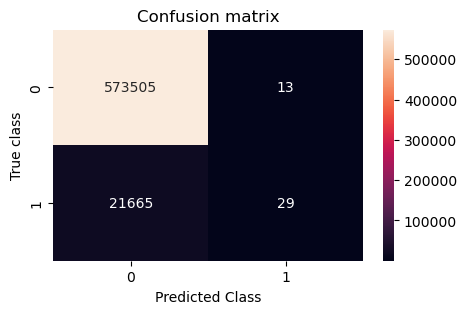

In [11]:
train_predicted_probabilities = test_pipe_line(train_df)

## Obtaining the predicted probabilities for test data in a csv file

In [12]:
id_column, test_predicted_probabilities = final_pipe_line(input_df)

In [13]:
submission = pd.DataFrame()
submission['id'] = id_column
submission['target'] = test_predicted_probabilities
submission.to_csv('final_predictions.csv', index = False)

## Results

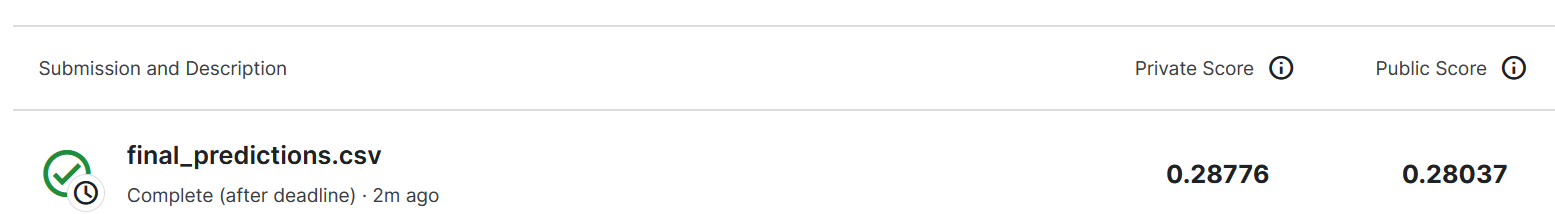

Using the LightGBM model, we got the final public score of 0.28 and private score of 0.2877 in Kaggle's Porto Seguro’s Safe Driver Prediction competition.